In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

In [ ]:
from colabgymrender.recorder import Recorder

In [ ]:
# install dependencies
!apt install chromium-browser xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
chromium-browser is already the newest version (1:85.0.4183.83-0ubuntu2.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.10).
0 upgraded, 0 newly installed, 0 to remove and 44 not upgraded.


In [ ]:
env = gym.make('CartPole-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0

while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.play()


  logger.warn(

  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  if not isinstance(terminated, (bool, np.bool8)):



73.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  93%|█████████▎| 70/75 [00:01<00:00, 52.32it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./video/1717334247.9502938.mp4, 720000 bytes wanted but 0 bytes read,at frame 74/75, at time 2.47/2.47 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
total_reward

73.0

In [ ]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 50000
epsilon_decay_intervals = 10000
gamma = 0.99 # discount
alpha = 5e-4 # learning rate

memory_size = 50000
min_replay_size = 1000
batch_size = 32

target_update_frequency = 1000 # target network update frequency

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 64),
            nn.Tanh(),
            nn.Linear(64, env.action_space.n)
        )

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

In [ ]:
def fill_memory(env):
    memory = deque(maxlen=memory_size)
    state = env.reset()
    for _ in range(min_replay_size):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()

    return memory

In [ ]:
def dqn_training(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr):
    q_net = NeuralNetwork(env)
    target_net = NeuralNetwork(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)

        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0


        # Take a batch of experiences from the memory
        experiences = random.sample(memory, batch_size)
        states = [ex[0] for ex in experiences]
        actions = [ex[1] for ex in experiences]
        rewards = [ex[2] for ex in experiences]
        dones = [ex[3] for ex in experiences]
        next_states = [ex[4] for ex in experiences]

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        # Compute targets using the formulation sample = r + gamma * max q(s',a')
        target_q_values = target_net(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rewards + gamma * (1-dones) * max_target_q_values

        # Compute loss
        q_values = q_net(states)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(action_q_values, targets)

        # gradient descent for q-network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update target network
        if (step+1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        # print training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')

    return all_rewards, q_net

In [ ]:
all_rewards, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Episode: 41 Step: 1000 Average reward: 24.170731707317074
Episode: 88 Step: 2000 Average reward: 22.636363636363637
Episode: 129 Step: 3000 Average reward: 22.98
Episode: 174 Step: 4000 Average reward: 22.59
Episode: 206 Step: 5000 Average reward: 25.46
Episode: 230 Step: 6000 Average reward: 29.83
Episode: 246 Step: 7000 Average reward: 36.06
Episode: 255 Step: 8000 Average reward: 43.45
Episode: 261 Step: 9000 Average reward: 52.06
Episode: 268 Step: 10000 Average reward: 60.78
Episode: 273 Step: 11000 Average reward: 68.59
Episode: 279 Step: 12000 Average reward: 77.37
Episode: 284 Step: 13000 Average reward: 85.33
Episode: 289 Step: 14000 Average reward: 93.77
Episode: 294 Step: 15000 Average reward: 102.17
Episode: 299 Step: 16000 Average reward: 110.06
Episode: 304 Step: 17000 Average reward: 118.74
Episode: 310 Step: 18000 Average reward: 129.07
Episode: 315 Step: 19000 Average reward: 137.05
Episode: 320 Step: 20000 Average reward: 145.86
Episode: 325 Step: 21000 Average reward

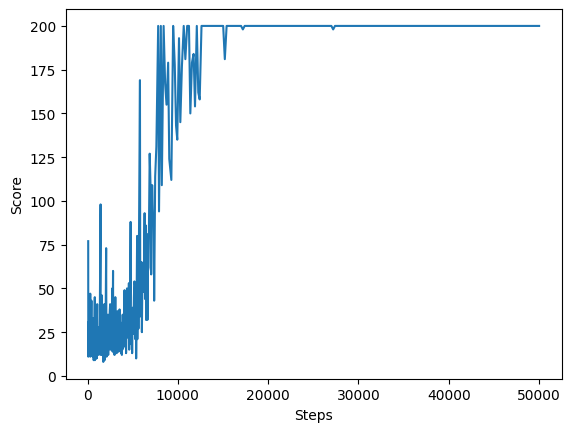

In [ ]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [ ]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



200.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


# **BÀI LÀM**

* Neural Network ban đầu đã được thay đổi thành Dueling Network. Vì Dueling Network vượt trội hơn Neural Network thông thường nhờ khả năng phân biệt rõ ràng giữa giá trị trạng thái và lợi thế của hành động, giúp cải thiện đáng kể độ chính xác trong việc dự đoán giá trị Q và tăng cường hiệu suất trong các môi trường có nhiều hành động khả thi.
* Bộ tham số mới đã được chọn thông qua quá trình tune tham số. Với bộ tham số  như sau:
  * max_epsilon = 1.0,

  * min_epsilon = 0.001,

  * max_num_steps = 60000,

  * epsilon_decay_intervals = 700,

  * gamma = 0.99,

  * lr = 0.0015,

  * memory_size = 10000,

  * min_replay_size = 1000,

  * batch_size = 64,

  * target_update_frequency = 100

In [ ]:
env1 = gym.make('MountainCar-v0')
env1 = Recorder(env1, './video')
state = env1.reset()
done = False
total_reward = 0.0

while not done:
    action = env1.action_space.sample()
    next_state, reward, done, info = env1.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env1.play()

  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  if not isinstance(terminated, (bool, np.bool8)):



-200.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
class DuelingNetwork(nn.Module):
    def __init__(self, env):
        super(DuelingNetwork, self).__init__()

        self.feature_layer = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 64),
            nn.Tanh()
        )

        # Advantage stream
        self.advantage_layer = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, env.action_space.n)
        )

        # Value stream
        self.value_layer = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, state):
        features = self.feature_layer(state)
        advantages = self.advantage_layer(features)
        values = self.value_layer(features)

        # Combine advantages and values to get Q-values
        q_values = values + (advantages - advantages.mean(dim=1, keepdim=True))

        return q_values

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0))  # PyTorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()


In [ ]:
def fill_memory1(env, memory_size, min_replay_size):
    memory = deque(maxlen=memory_size)
    state = env.reset()
    for _ in range(min_replay_size):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()

    return memory

In [ ]:
def dqn_training1(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr, memory_size, min_replay_size, batch_size, target_update_frequency):
    q_net = DuelingNetwork(env)
    target_net = DuelingNetwork(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory1(env, memory_size, min_replay_size)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)

        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0


        # Take a batch of experiences from the memory
        experiences = random.sample(memory, batch_size)
        states = [ex[0] for ex in experiences]
        actions = [ex[1] for ex in experiences]
        rewards = [ex[2] for ex in experiences]
        dones = [ex[3] for ex in experiences]
        next_states = [ex[4] for ex in experiences]

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        # Compute targets using the formulation sample = r + gamma * max q(s',a')
        target_q_values = target_net(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rewards + gamma * (1-dones) * max_target_q_values

        # Compute loss
        q_values = q_net(states)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(action_q_values, targets)

        # gradient descent for q-network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update target network
        if (step+1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        # print training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')

    return all_rewards, q_net

In [ ]:
# param_grid = {
#     'max_num_steps': [60000],
#     'max_epsilon': [1.0],
#     'min_epsilon': [0.001],
#     'epsilon_decay_intervals': [600, 700, 800],
#     'gamma': [0.99],
#     'lr': [0.001, 0.0015],
#     'memory_size': [10000],
#     'min_replay_size': [1000],
#     'batch_size': [64],
#     'target_update_frequency': [50, 100, 150],
# }

In [ ]:
# import itertools
# import numpy as np

# def grid_search_dqn(env, param_grid):
#     keys, values = zip(*param_grid.items())
#     best_params = None
#     best_reward = -np.inf
#     all_results = []

#     for combination in itertools.product(*values):
#         params = dict(zip(keys, combination))
#         print(f"Testing with parameters: {params}")

#         all_rewards, q_net = dqn_training(env, **params)
#         average_reward = np.mean([reward for step, reward in all_rewards[-100:]])

#         all_results.append((params, average_reward))

#         if average_reward > best_reward:
#             best_reward = average_reward
#             best_params = params

#     return best_params, best_reward, all_results

In [ ]:
# env1 = gym.make('MountainCar-v0')
# best_params, best_reward, all_results = grid_search_dqn(env1, param_grid)

In [ ]:
# print(f"Best parameters: {best_params}")
# print(f"Best average reward: {best_reward}")

In [ ]:
max_epsilon = 1.0
min_epsilon = 0.001
max_num_steps = 60000
epsilon_decay_intervals = 700
gamma = 0.99
lr = 0.0015

memory_size = 10000
min_replay_size = 1000
batch_size = 64

target_update_frequency = 100

In [ ]:
all_rewards1, q_net1 = dqn_training1(env1, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr, memory_size, min_replay_size, batch_size, target_update_frequency)

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Episode: 5 Step: 1000 Average reward: -200.0
Episode: 10 Step: 2000 Average reward: -200.0
Episode: 15 Step: 3000 Average reward: -200.0
Episode: 20 Step: 4000 Average reward: -200.0
Episode: 25 Step: 5000 Average reward: -200.0
Episode: 30 Step: 6000 Average reward: -198.3
Episode: 35 Step: 7000 Average reward: -198.54285714285714
Episode: 40 Step: 8000 Average reward: -198.725
Episode: 45 Step: 9000 Average reward: -198.86666666666667
Episode: 50 Step: 10000 Average reward: -198.98
Episode: 55 Step: 11000 Average reward: -199.07272727272726
Episode: 60 Step: 12000 Average reward: -199.15
Episode: 65 Step: 13000 Average reward: -199.2153846153846
Episode: 70 Step: 14000 Average reward: -199.27142857142857
Episode: 75 Step: 15000 Average reward: -199.32
Episode: 80 Step: 16000 Average reward: -199.3625
Episode: 85 Step: 17000 Average reward: -199.4
Episode: 90 Step: 18000 Average reward: -199.43333333333334
Episode: 95 Step: 19000 Average reward: -199.46315789473684
Episode: 100 Step: 

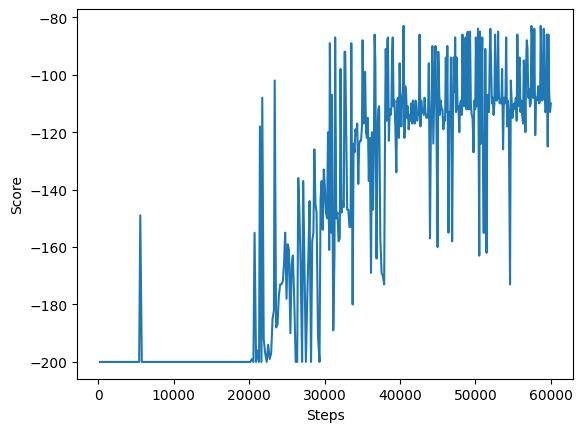

In [ ]:
all_rewards1 = np.array(all_rewards1)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards1[:, 0], all_rewards1[:, 1])

In [ ]:
env1 = Recorder(env1, './video')
state = env1.reset()
done = False
total_reward = 0.0
q_net1.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net1.choose_action(state)
        next_state, reward, done, info = env1.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env1.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-84.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
